# Conformal Prediction Interval Counterfactual Demo

In [ ]:
# Colab package installation
!git clone -b COPA_demo https://github.com/alan-turing-institute/CPICF.git
#!git branch COPA_demo
#
from google.colab import files
files._os.chdir('./CPICF')
!pip install -r requirements.txt

- [Generate Data](#1-generate-data)
- [Conformal Prediction Intervals](#2-conformal-prediction-intervals)
- [Compute Counterfactuals](#3-compute-counterfactuals)

In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
from utils.datautil import syntheticdataset
from utils.xgbutil import XGBclassifierwrapper
from utils.plotutil import plot_performance, plot_uncertainty, get_minimised_counterfactual_list
from utils.disputil import LACPwrapper
from utils.CFutils import get_confidenceinterval
import pprint
import numpy as np
import matplotlib.pyplot  as plt
import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Generate Data

{'n_features': 2,
 'n_samples': 30000,
 'n_classes': 2,
 'class_sep': 1.5,
 'n_redundant': 0,
 'weights': (0.9, 0.1),
 'random_state': 42}


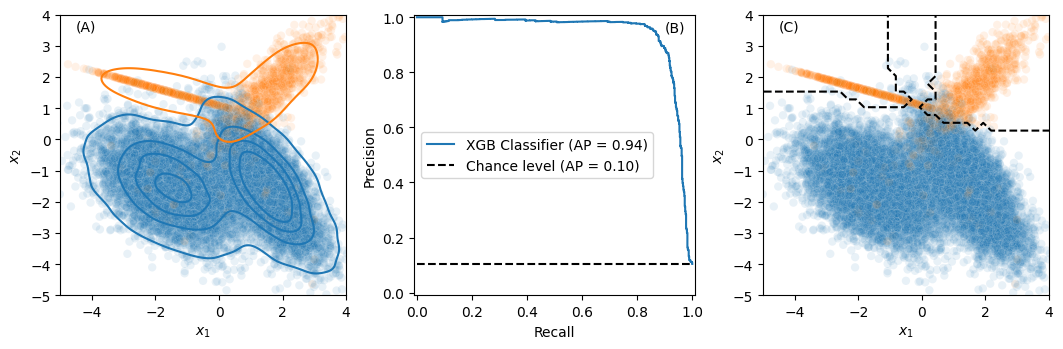

In [4]:
# Create a dataset
dataset = syntheticdataset()
pprint.pp(dataset.params)
# Create Bank Classifier
XGBclassifiermodel = XGBclassifierwrapper(dataset.X_train, dataset.y_train, savepath = None)
plot_performance(dataset, XGBclassifiermodel.search_cv)


### 2. Conformal Prediction Intervals

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


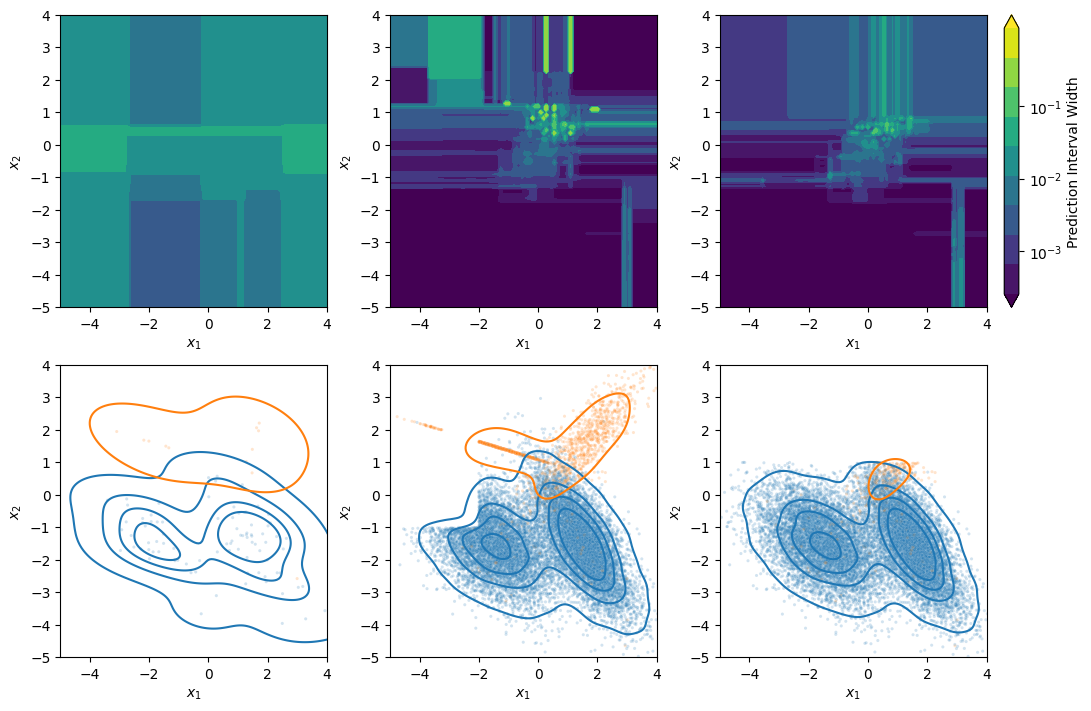

In [8]:
# Examples of how the user dataset might differ from the full training data
idxes = np.random.choice(len(dataset.y_fit), 100, replace = False)
mask0 = np.array([x in idxes for x in range(len(dataset.y_fit))])
mask1 = np.logical_or(
    np.logical_or(
    dataset.X_fit[:,1]<-1, dataset.X_fit[:,1]>2
    ),
    np.logical_or(
        dataset.X_fit[:,0]<-5,dataset.X_fit[:,0]>-2
    )
)
mask2 = dataset.X_fit[:,1]<1

masklist = [mask0, mask1, mask2]
X_fit_limited_list = []
y_fit_limited_list = []
y_fit_reg_limited_list = []
XGBLACP_list = []

y_calib_reg = XGBclassifiermodel.search_cv.predict_proba(dataset.X_calib)[:,1]
 # Create a LACP based on labelling
for i in range(len(masklist)):
    mask = masklist[i]
    X_fit_limited_list.append(dataset.X_fit[mask])
    y_fit_limited_list.append(dataset.y_fit[mask])
    y_fit_reg_limited_list.append(XGBclassifiermodel.search_cv.predict_proba(X_fit_limited_list[i])[:,1] )
    
    XGBLACP_list.append( LACPwrapper(X_fit_limited_list[i], y_fit_reg_limited_list[i], dataset.X_calib, y_calib_reg) )


plot_uncertainty(X_fit_limited_list, y_fit_limited_list, XGBLACP_list)


### 3. Compute Counterfactuals

100%|██████████| 8/8 [00:00<00:00, 10.14it/s]


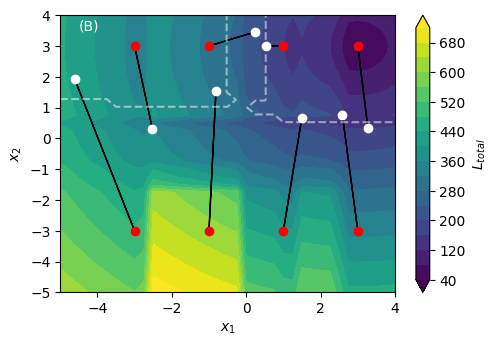

In [30]:

xlin = np.linspace(-3,3, 4)
ylin = np.linspace(-3,3,2)
xinstlist = [np.array([x, y ]) for x in xlin for y in ylin]
fig, ax = plt.subplots(1,1, figsize = (5.4, 3.6))

def CIhelper(X, alpha = 0.2 ):
    return get_confidenceinterval(X, XGBLACP_list[0].lacp)

get_minimised_counterfactual_list(xinstlist, CIhelper, XGBclassifiermodel.search_cv, ll = 50, alpha = .2, ax = ax)